In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Initialize Sparks Contest

In [2]:
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import pandas as pd

import plotly.graph_objects as go
import numpy as np

In [3]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession 
from pyspark.conf import SparkConf
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import StringType, IntegerType, StructType, StructField

In [4]:
spark = SparkSession \
    .builder \
    .appName("regression") \
    .master("local[4]") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.network.timeout","3600")\
    .config("spark.executor.heartbeatInterval","3000s")\
    .getOrCreate()

# Read Dataset

In [5]:
spark

In [6]:
df = spark.read.json('../data/cleaned_dataset')
df.show(3,truncate=False,vertical =True)
df.count()

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------
 acousticness          | 0.658                                                                                                                              
 age                   | 41.821917808219176                                                                                                                 
 avg_artist_followers  | 5403.5                                                                                                                             
 avg_artist_popularity | 40.0                                                                                                                               
 danceability          | 0.602                                                                                                                              
 duration_ms           | 156067                           

583363

In [7]:
df.printSchema()

root
 |-- acousticness: double (nullable = true)
 |-- age: double (nullable = true)
 |-- avg_artist_followers: double (nullable = true)
 |-- avg_artist_popularity: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- energy: double (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id_track: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: long (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- popularity_track: long (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- sum_artist_followers: long (nullable = true)
 |-- sum_artist_popularity: long (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: long (nullable = true)
 |-- valence: double (nullable = true)



# Data Preparation 

In [8]:

df = df.na.drop(how='any')
df.count()

583363

In [9]:
df.columns

['acousticness',
 'age',
 'avg_artist_followers',
 'avg_artist_popularity',
 'danceability',
 'duration_ms',
 'energy',
 'genres',
 'id_track',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity_track',
 'release_date',
 'speechiness',
 'sum_artist_followers',
 'sum_artist_popularity',
 'tempo',
 'time_signature',
 'valence']

In [10]:
all_numerical_columns = ['acousticness', 'age', 'avg_artist_followers', 'avg_artist_popularity', 'danceability', 'duration_ms',
    'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',  'speechiness',
    'sum_artist_followers', 'sum_artist_popularity', 'tempo', 'time_signature', 'valence','popularity_track']

technical_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',  'speechiness', 'tempo', 'time_signature', 'valence','popularity_track']

In [11]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=technical_columns,
    outputCol="features")

df = assembler.transform(df)
df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[0.658,0.602,1560...|
|[0.543,0.77,22013...|
|[4.8E-5,0.212,250...|
|[0.144,0.362,4570...|
|[0.957,0.343,2828...|
|[0.119,0.893,2170...|
|[0.96,0.351,54510...|
|[0.168,0.422,2569...|
|[0.775,0.627,2491...|
|[0.971,0.554,1898...|
|[0.945,0.189,1817...|
|[0.0904,0.46,2030...|
|[0.868,0.764,2132...|
|[0.81,0.413,28202...|
|[0.69,0.829,16121...|
|[0.0451,0.632,237...|
|[0.501,0.442,2442...|
|[0.0424,0.582,207...|
|[0.136,0.881,2006...|
|[0.44,0.686,17826...|
+--------------------+
only showing top 20 rows



### CORRELATION

<AxesSubplot:>

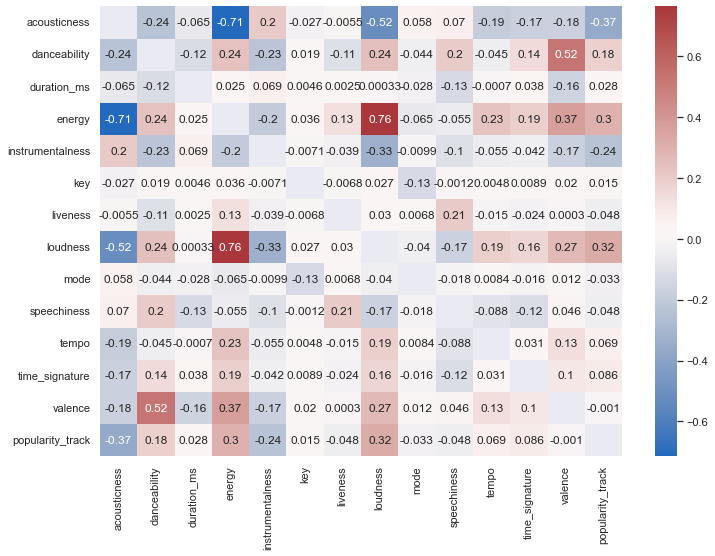

In [12]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
corrMat = Correlation.corr(df, "features").head()[0]

corr_mat = pd.DataFrame(corrMat.toArray(),index=technical_columns,columns=technical_columns)
for i in corr_mat: corr_mat.loc[i,i] = np.nan
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr_mat,cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=technical_columns, yticklabels=technical_columns,annot=True)

<AxesSubplot:>

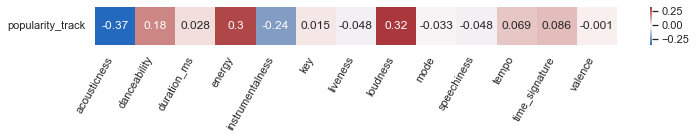

In [13]:
technical_columns.remove('popularity_track')
sns.set(rc={'figure.figsize':(11.7,0.7)})
heatmap = sns.heatmap(corr_mat.loc[['popularity_track'],technical_columns],cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=technical_columns, yticklabels=['popularity'],annot=True)
heatmap.set_xticklabels(technical_columns, rotation=60,horizontalalignment='right')
heatmap.set_yticklabels(['popularity_track'], rotation=0) 
heatmap

In [14]:

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=all_numerical_columns,
    outputCol="allFeatures")

df = assembler.transform(df)
df.select('allFeatures').show()

+--------------------+
|         allFeatures|
+--------------------+
|[0.658,41.8219178...|
|[0.543,45.8246575...|
|[4.8E-5,25.673972...|
|[0.144,31.8136986...|
|[0.957,4.07123287...|
|[0.119,13.8027397...|
|[0.96,71.84109589...|
|[0.168,6.66575342...|
|[0.775,30.6246575...|
|[0.971,20.8054794...|
|[0.945,61.8356164...|
|[0.0904,38.468493...|
|[0.868,16.0191780...|
|[0.81,30.81369863...|
|[0.69,25.60821917...|
|[0.0451,33.010958...|
|[0.501,5.98904109...|
|[0.0424,5.2410958...|
|[0.136,0.50410958...|
|[0.44,2.575342465...|
+--------------------+
only showing top 20 rows



<AxesSubplot:>

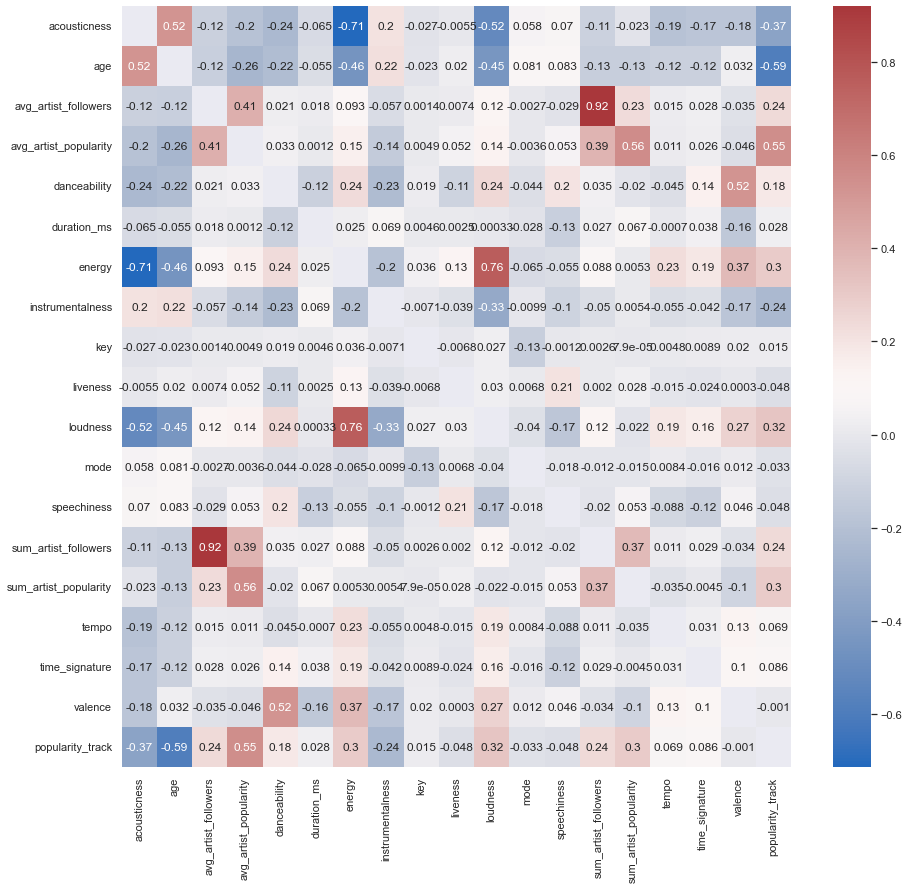

In [15]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
corrMat = Correlation.corr(df, "allFeatures").head()[0]

corr_mat = pd.DataFrame(corrMat.toArray(),index=all_numerical_columns,columns=all_numerical_columns)
for i in corr_mat: corr_mat.loc[i,i] = np.nan
sns.set(rc={'figure.figsize':(15,14)})
sns.heatmap(corr_mat,cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=all_numerical_columns, yticklabels=all_numerical_columns,annot=True)

<AxesSubplot:>

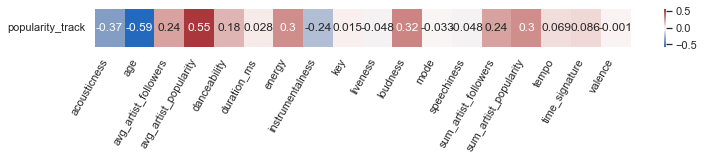

In [16]:
all_numerical_columns.remove('popularity_track')
sns.set(rc={'figure.figsize':(12,0.7)})
heatmap = sns.heatmap(corr_mat.loc[['popularity_track'],all_numerical_columns],cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=all_numerical_columns, yticklabels=['popularity'],annot=True)
heatmap.set_xticklabels(all_numerical_columns, rotation=60,horizontalalignment='right')
heatmap.set_yticklabels(['popularity_track'], rotation=0) 
heatmap

### POPULARITI DISTRIBUTION

In [17]:
import pyspark.sql.functions as F

def value_counts(spark_df, colm, order=1, n=10):

    if order==1 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc_nulls_first("count")).head(n),columns=["value","count"]) 
    if order==2 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.asc(colm)).head(n),columns=["value","count"]) 
    if order==3 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc(colm)).head(n),columns=["value","count"]) 
    if order==4 :
        return pd.concat([pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.asc(colm)).head(n),columns=["value","count"]),
                          pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc(colm)).head(n),columns=["value","count"])])

In [18]:
count = value_counts(df, 'popularity_track', order=2, n=100)
count

,value,count
0,0,43901
1,1,11734
2,2,9415
3,3,7995
4,4,7607
...,...,...
95,95,1
96,96,2
97,97,2
98,98,1


Text(0.5, 0, 'Popularity')

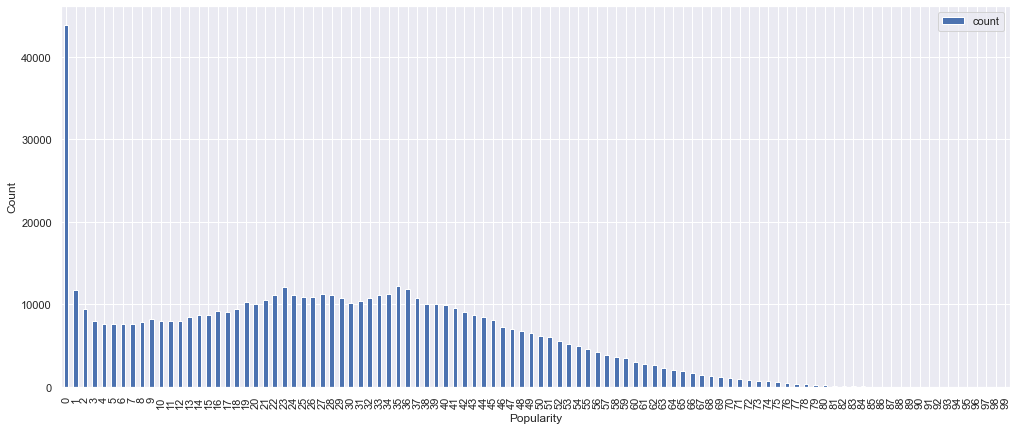

In [19]:
sns.set(rc={'figure.figsize':(17,7)})
count.plot.bar('value','count')
plt.ylabel('Count')
plt.xlabel('Popularity')

In [20]:
from pyspark.ml.feature import QuantileDiscretizer 

qds = QuantileDiscretizer(relativeError=0.0001, handleInvalid="error", numBuckets=10, inputCol="popularity_track", outputCol="popularity_class")

df = qds.setHandleInvalid("keep").fit(df).transform(df)

Text(0.5, 0, 'Popularity')

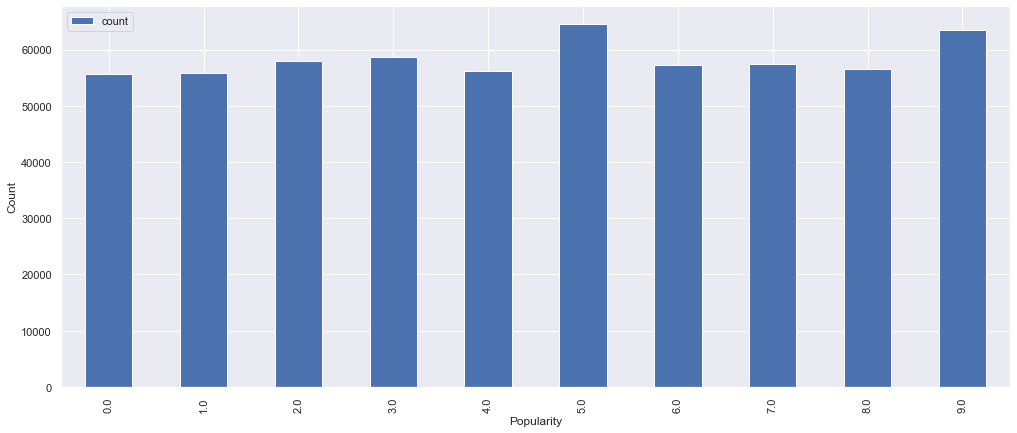

In [21]:
count = value_counts(df, 'popularity_class', order=2, n=100)
sns.set(rc={'figure.figsize':(17,7)})
count.plot.bar('value','count')
plt.ylabel('Count')
plt.xlabel('Popularity')

In [22]:
df = df.drop('features')
df = df.drop('allFeatures')

In [23]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=technical_columns,
    outputCol="features")

df = assembler.transform(df)
df.select('features').show()

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=all_numerical_columns,
    outputCol="allFeatures")

df = assembler.transform(df)
df.select('allFeatures').show()

+--------------------+
|            features|
+--------------------+
|[0.658,0.602,1560...|
|[0.543,0.77,22013...|
|[4.8E-5,0.212,250...|
|[0.144,0.362,4570...|
|[0.957,0.343,2828...|
|[0.119,0.893,2170...|
|[0.96,0.351,54510...|
|[0.168,0.422,2569...|
|[0.775,0.627,2491...|
|[0.971,0.554,1898...|
|[0.945,0.189,1817...|
|[0.0904,0.46,2030...|
|[0.868,0.764,2132...|
|[0.81,0.413,28202...|
|[0.69,0.829,16121...|
|[0.0451,0.632,237...|
|[0.501,0.442,2442...|
|[0.0424,0.582,207...|
|[0.136,0.881,2006...|
|[0.44,0.686,17826...|
+--------------------+
only showing top 20 rows

+--------------------+
|         allFeatures|
+--------------------+
|[0.658,41.8219178...|
|[0.543,45.8246575...|
|[4.8E-5,25.673972...|
|[0.144,31.8136986...|
|[0.957,4.07123287...|
|[0.119,13.8027397...|
|[0.96,71.84109589...|
|[0.168,6.66575342...|
|[0.775,30.6246575...|
|[0.971,20.8054794...|
|[0.945,61.8356164...|
|[0.0904,38.468493...|
|[0.868,16.0191780...|
|[0.81,30.81369863...|
|[0.69,25.60821917...|
|[0.0451

### SCALING

In [24]:
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df)

# Normalize each feature to have unit standard deviation.
df = scalerModel.transform(df)
df.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[1.89001213665070...|
|[1.55969086656737...|
|[1.37873225773911...|
|[0.41361967732173...|
|[2.74884743886736...|
+--------------------+
only showing top 5 rows



In [25]:


scaler1 = StandardScaler(inputCol="allFeatures", outputCol="allScaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler1.fit(df)

# Normalize each feature to have unit standard deviation.
df = scalerModel.transform(df)
df.select('allScaledFeatures').show(5)

+--------------------+
|   allScaledFeatures|
+--------------------+
|[1.89001213665070...|
|[1.55969086656737...|
|[1.37873225773911...|
|[0.41361967732173...|
|[2.74884743886736...|
+--------------------+
only showing top 5 rows



In [26]:
df.printSchema()

root
 |-- acousticness: double (nullable = true)
 |-- age: double (nullable = true)
 |-- avg_artist_followers: double (nullable = true)
 |-- avg_artist_popularity: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- energy: double (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id_track: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: long (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- popularity_track: long (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- sum_artist_followers: long (nullable = true)
 |-- sum_artist_popularity: long (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: long (nullable = true)
 |-- valence: double (nullable = true)
 |-- popularit

In [27]:
train, test = df.randomSplit([0.7, 0.3])

# Linear Regression

In [28]:
from pyspark.ml.linalg import Vectors
from pyspark.mllib.tree import RandomForest

#### All columns

In [29]:
from pyspark.ml.regression import LinearRegression



lr = LinearRegression(featuresCol="scaledFeatures",labelCol='popularity_track', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [-4.467378169163006,2.4024302711438246,0.0,0.08242655283154461,-2.3044134962108656,0.0,-0.530465478707977,2.7231913020164242,0.0,-0.34086719313761676,0.0,0.0,-2.9692563637423044]
Intercept: 38.68652495272196
numIterations: 11
objectiveHistory: [0.5, 0.4731665146868369, 0.41715309036558557, 0.41256447475047625, 0.4083754957839336, 0.4081318467161878, 0.4080385072403504, 0.4079783143238997, 0.40795426797939216, 0.4079322419408633, 0.4079270622483301]
+-------------------+
|          residuals|
+-------------------+
|  10.35792688272474|
|-19.516409358824873|
| 14.204663052616674|
|  3.884757767531113|
|   6.58354013490149|
|  -6.41645986509851|
|  -6.41645986509851|
|  7.146340368909009|
|-19.050968797316358|
| -26.26687061969486|
|-28.815172223315358|
| -24.65107052667686|
|  4.222370069764928|
| -5.283827465055463|
|  18.70812016594671|
|-16.111948950339986|
|-24.111948950339986|
|0.26633039328286046|
|  -3.69225471969564|
|  4.414420592258171|
+-------------------+
only 

In [30]:
lrModel.coefficients

DenseVector([-4.4674, 2.4024, 0.0, 0.0824, -2.3044, 0.0, -0.5305, 2.7232, 0.0, -0.3409, 0.0, 0.0, -2.9693])

In [31]:
from  pyspark.ml.evaluation import RegressionEvaluator

# Make predictions.
predictions = lrModel.transform(test)


evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 16.3406
R sqaure = 0.206392


In [32]:
train = train.drop('prediction')
train = train.withColumn('prediction',col('popularity_track'))
qds = QuantileDiscretizer(relativeError=0.0001, handleInvalid="error", numBuckets=10, inputCol="prediction", outputCol="prediction_class")

predictions = qds.setHandleInvalid("keep").fit(train).transform(predictions)


evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 2.56112
R sqaure = 0.202131


In [33]:
from pyspark.ml.regression import LinearRegression
train = train.drop('prediction')

lr = LinearRegression(featuresCol="allScaledFeatures",labelCol='popularity_track', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [-0.2539493489564046,-7.793258057816619,0.0,7.7080583885797225,0.7021480834573176,0.0,0.0,-0.935088337869331,0.0,-0.7744660608273809,0.5021517987111253,0.0,-0.3989081276773385,0.0,0.0,0.0,0.0,0.0]
Intercept: 21.21616016697075
numIterations: 11
objectiveHistory: [0.5, 0.4506779000682198, 0.2763663177683029, 0.26354133370719224, 0.25003887931351404, 0.2484291672592973, 0.24771771116581412, 0.247534490172023, 0.24746443155590628, 0.24745234928073528, 0.24744784758442778]
+-------------------+
|          residuals|
+-------------------+
|  18.48946012682712|
|-14.651323557431034|
| 14.181188793445983|
| 0.9507754278020677|
| -3.076434815261635|
| -9.709424999163351|
| -9.709424999163351|
|  26.99582949732156|
| -23.10837401115813|
|-14.250572647668369|
|-24.894773543096363|
|-22.271482290165224|
|   29.7912444794575|
|  4.046511043536601|
| 20.686064105944837|
|-25.881760244747397|
|  -33.8817602447474|
| 6.3156648697329025|
|-13.455354456254234|
|  2.976938434396942|
+------

In [34]:
lrModel.coefficients

DenseVector([-0.2539, -7.7933, 0.0, 7.7081, 0.7021, 0.0, 0.0, -0.9351, 0.0, -0.7745, 0.5022, 0.0, -0.3989, 0.0, 0.0, 0.0, 0.0, 0.0])

In [35]:
print(all_numerical_columns)

['acousticness', 'age', 'avg_artist_followers', 'avg_artist_popularity', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'sum_artist_followers', 'sum_artist_popularity', 'tempo', 'time_signature', 'valence']


In [36]:
# Make predictions.
predictions = lrModel.transform(test)


evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 12.5351
R sqaure = 0.53299


In [37]:
train = train.drop('prediction')
train = train.withColumn('prediction',col('popularity_track'))
qds = QuantileDiscretizer(relativeError=0.0001, handleInvalid="error", numBuckets=10, inputCol="prediction", outputCol="prediction_class")

predictions = qds.setHandleInvalid("keep").fit(train).transform(predictions)


evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 1.96146
R sqaure = 0.532014


# Random Forest Regressor

In [48]:
train, test = df.randomSplit([0.7, 0.3])

#### TECHNICAL COLUMNS

In [49]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator



# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="scaledFeatures",labelCol='popularity_track')



# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)


# Select example rows to display.
predictions.select("prediction", "popularity_track", "scaledFeatures").show(5)

+------------------+----------------+--------------------+
|        prediction|popularity_track|      scaledFeatures|
+------------------+----------------+--------------------+
|22.555553451241117|              32|(13,[2,3,4,5,6,7,...|
|20.694863408676788|               0|(13,[2,7],[0.0316...|
|28.947593585765162|              33|[3.07342399121011...|
|16.312973429167528|               2|[3.15959475731881...|
|28.548041242446704|               0|[3.30321270083330...|
+------------------+----------------+--------------------+
only showing top 5 rows



In [50]:


evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 15.7823
R sqaure = 0.2596


In [51]:
train = train.drop('prediction')
train = train.withColumn('prediction',col('popularity_track'))
qds = QuantileDiscretizer(relativeError=0.0001, handleInvalid="error", numBuckets=10, inputCol="prediction", outputCol="prediction_class")

predictions = qds.setHandleInvalid("keep").fit(train).transform(predictions)


evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 2.46441
R sqaure = 0.260751


In [52]:
model.featureImportances

SparseVector(13, {0: 0.4716, 1: 0.0274, 2: 0.0688, 3: 0.1154, 4: 0.0873, 6: 0.008, 7: 0.1766, 9: 0.0176, 10: 0.0013, 11: 0.0004, 12: 0.0258})

### ALL COLUMNS




In [42]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

train = train.drop('prediction')

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="allScaledFeatures",labelCol='popularity_track')



# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)


# Select example rows to display.
predictions.select("prediction", "popularity_track", "allScaledFeatures").show(5)

+------------------+----------------+--------------------+
|        prediction|popularity_track|   allScaledFeatures|
+------------------+----------------+--------------------+
|13.228616145852541|              32|(18,[1,5,6,7,8,9,...|
| 21.21974679400523|               7|[0.0,0.6909282357...|
|21.020249515645734|              14|[3.10214757991301...|
| 23.90126621091562|               2|[4.02130241840576...|
|30.459131370939723|              52|[4.30853830543474...|
+------------------+----------------+--------------------+
only showing top 5 rows



In [43]:


evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_track", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 12.1462
R sqaure = 0.560223


In [44]:
train = train.drop('prediction')
train = train.withColumn('prediction',col('popularity_track'))
qds = QuantileDiscretizer(relativeError=0.0001, handleInvalid="error", numBuckets=10, inputCol="prediction", outputCol="prediction_class")

predictions = qds.setHandleInvalid("keep").fit(train).transform(predictions)


evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="popularity_class", predictionCol="prediction_class", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 1.9157
R sqaure = 0.55258


In [46]:
model.trees

[DecisionTreeRegressionModel (uid=dtr_5a0aeb354951) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_012be5c0ff91) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_c10d352f2c27) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_375c59f8e0b3) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_e72b95c9d4f2) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_015ead7aea38) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_713b12850f89) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_d3e1782216fc) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_0dc9f0a4bbd3) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_536dddc8631f) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_7983a37260c7) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_17d3a9b2c939) of depth 5 with 63 nodes,
 DecisionTreeRegressionModel (uid=dtr_07801994b930) of depth 5 w

In [47]:
model.featureImportances

SparseVector(18, {0: 0.0556, 1: 0.4432, 2: 0.084, 3: 0.2008, 4: 0.001, 5: 0.0054, 6: 0.0159, 7: 0.0061, 9: 0.0005, 10: 0.0143, 12: 0.0009, 13: 0.0833, 14: 0.0887, 17: 0.0003})